#Step 1: Install Libraries

In [80]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#Machine Learning
from sklearn import tree
import graphviz
from sklearn import metrics
from sklearn.linear_model import LinearRegression

#Install TALIB---------------------------------------------------------
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib as ta

#Install Pyfolio------------------------------------------------------
!pip install pyfolio
import pyfolio as pf

#Install Yahoo Finance------------------------------------------------
!pip install yfinance
import yfinance as yf

<ipython-input-80-429f769a2856>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


--2024-01-04 07:14:17--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-04 07:14:18--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-04 07:14:18--  http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netactuat



---



#Step 2: Import Dataset & Plot

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,11.44,11.44,11.37,11.40,10.224250,2115000
2022-01-04,11.51,11.70,11.48,11.70,10.493310,6323300
2022-01-05,11.72,11.74,11.55,11.58,10.385686,3735700
2022-01-06,11.55,11.70,11.50,11.68,10.475373,3953100
2022-01-07,11.79,11.96,11.73,11.88,10.654745,8678000
...,...,...,...,...,...,...
2023-07-18,12.47,12.50,12.42,12.47,12.088655,3067400
2023-07-19,12.53,12.68,12.53,12.67,12.282538,6147700
2023-07-20,12.70,12.70,12.55,12.64,12.253456,3875900


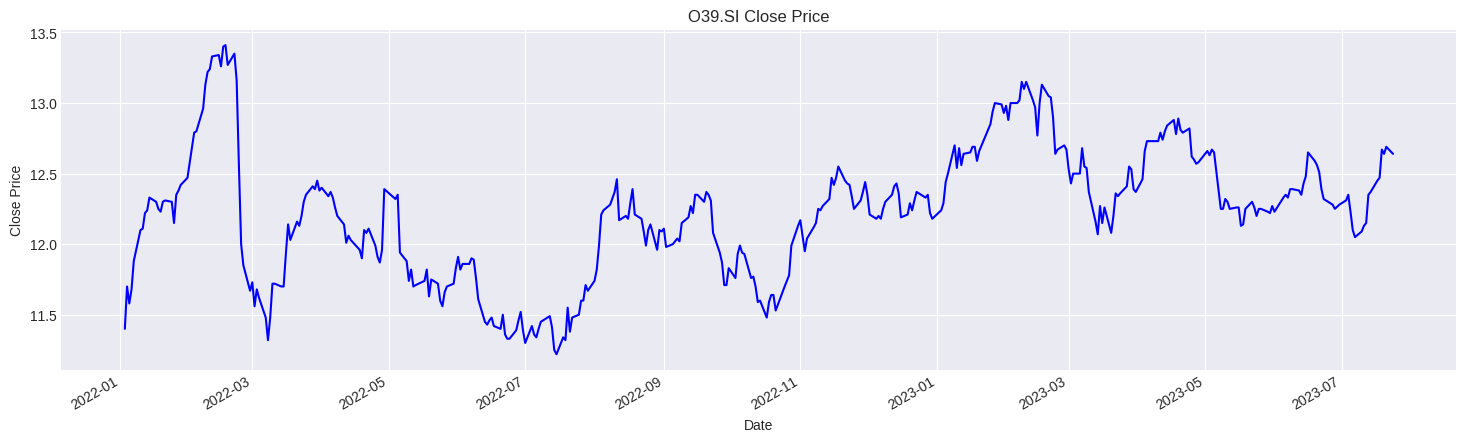

In [139]:
ticker = 'O39.SI'
data = yf.download(ticker,start='2022-01-01', end='2023-07-25')
display(data)

#we only want the Close price
#data = pd.DataFrame(data['Close'])
#display(data)

#Plot---------------------------------------
data.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()



---



#Step 3: Define Features and Target

In [164]:
def get_target_features(data):

    # -------------------------------------------------------------
    # Define Features (X)
    #Volatility
    #(we use the pct_change() to get the Volatility)
    data['PCT_CHANGE'] = data['Close'].pct_change()
    data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100

    #Correlation
    #(we use the SMA to get the CORR)
    data['SMA'] = ta.SMA(data['Close'],14)
    data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)

    #RSI
    data['RSI'] = ta.RSI(data['Close'].values, timeperiod=14)

    #ADX
    data['ADX'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=14)


    # ------------------------------------------------------------
    # Define Target (y)
    data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)

    # Create the signal column
    data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)

    data = data.dropna()

    return data['Actual_Signal'], data[['VOLATILITY', 'CORR', 'RSI', 'ADX','SMA']]
    #return data['Actual_Signal'], data[['VOLATILITY', 'CORR', 'ADX']]
#print(data['Actual_Signal'])

<Axes: >

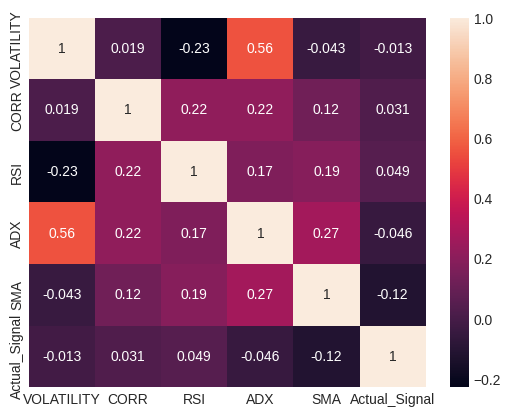

In [176]:
correlations=data[['VOLATILITY', 'CORR', 'RSI', 'ADX','SMA', 'Actual_Signal']].corr()
sns.heatmap(correlations, annot=True)



---



#Step 4: Train Test Split

In [165]:
y, X = get_target_features(data)

split = int(0.8*len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
X_train.head()

,VOLATILITY,CORR,RSI,ADX,SMA
Date,,,,,
2022-02-11,0.905440,0.959560,88.980222,67.095878,12.703572
2022-02-14,0.905708,0.958594,89.064254,68.102844,12.777143
2022-02-15,0.944564,0.930639,83.573807,68.122116,12.845714
2022-02-16,0.803274,0.916881,85.283542,67.746052,12.935000
2022-02-17,0.770773,0.898510,85.400438,67.688422,13.010714




---



#Step 5: Scaling

In [166]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_test

array([[-0.07634063,  0.28594741,  0.68831172, -0.54267086,  0.65400156],
       [-0.56947424,  0.8545397 ,  0.68831172, -0.53358819,  0.75971611],
       [-0.63860261,  1.11289461,  0.86179037, -0.53152505,  0.85567248],
       [-0.75211025,  1.13108088,  0.63640453, -0.55581143,  0.91747489],
       [-0.77293753,  1.18415203,  0.82129948, -0.56824577,  0.99228831],
       [-0.77477054,  1.22638055,  0.94230596, -0.53141714,  1.07035457],
       [-0.77785527,  1.24270823,  1.06300208, -0.51210385,  1.14679442],
       [-0.76040565,  1.20473809,  0.56231381, -0.50954921,  1.18420105],
       [-0.6909019 ,  1.22111794,  0.9143882 , -0.4909522 ,  1.24275078],
       [-0.89990828,  1.12812397,  0.53716515, -0.49055601,  1.3110587 ],
       [-0.90076386,  1.0059408 ,  0.44475544, -0.56915451,  1.37936662],
       [-0.95294765,  0.96861774,  0.55412596, -0.61610763,  1.4379162 ],
       [-0.86312816, -0.13545463, -0.3044753 , -0.67211678,  1.43141069],
       [-0.93314931, -0.75115113, -0.3



---



#Step 6: Define, Train the Model and Predict

##6a) Define and Train the Model

In [167]:
model = LinearRegression()
model = model.fit(X_train,y_train)

##6b) Use the Model to Predict y_pred

In [168]:
y_pred = model.predict(X_test)

In [169]:
display(y_pred)

array([0.48824364, 0.4880458 , 0.48969508, 0.48083605, 0.48074156,
       0.47828934, 0.4757041 , 0.46244352, 0.46636728, 0.45060661,
       0.44312252, 0.44108474, 0.40416873, 0.39214946, 0.38371795,
       0.38107219, 0.38969206, 0.38467138, 0.39002074, 0.39391088,
       0.41091869, 0.430957  , 0.45124047, 0.45688242, 0.45950513,
       0.46544254, 0.46708812, 0.46438391, 0.46974242, 0.48636706,
       0.49236464, 0.49016134, 0.48598127, 0.48581473, 0.47182781,
       0.47303802, 0.46756789, 0.46526309, 0.45894108, 0.46366287,
       0.45729671, 0.45698095, 0.47765961, 0.48236962, 0.48416003,
       0.48696195, 0.5026657 , 0.50673715, 0.52033575, 0.50660883,
       0.49710929, 0.48521784, 0.46395001, 0.44824855, 0.43854869,
       0.43095697, 0.42603471, 0.4297313 , 0.43283142, 0.43325481,
       0.42263368, 0.42915195, 0.45074101, 0.4714456 , 0.48452953,
       0.4922438 , 0.50773807, 0.4985847 , 0.4963722 , 0.4909896 ,
       0.50091232, 0.49343783, 0.49503849])

In [170]:
y_pred = np.where(y_pred>0.5,1,0)

In [171]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0])



---



#Step 7: Confusion Matrix and Accuracy Metric

In [172]:
def get_metrics(y_test, predicted):
    confusion_matrix_data = metrics.confusion_matrix(y_test, predicted)
    # Plot the data

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print('\n\n\n',metrics.classification_report(y_test, predicted))


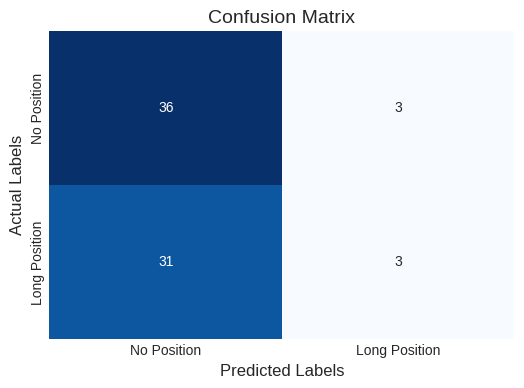




               precision    recall  f1-score   support

           0       0.54      0.92      0.68        39
           1       0.50      0.09      0.15        34

    accuracy                           0.53        73
   macro avg       0.52      0.51      0.41        73
weighted avg       0.52      0.53      0.43        73



In [173]:
get_metrics(y_test, y_pred)



---



#Step 8: Backtesting Our Model

In [174]:
ticker = 'O39.SI'
df = yf.download(ticker,start='2016-01-01', end='2017-01-01')
#df = yf.download(ticker,start='2021-01-01', end='2022-01-01')
#we change the dates
#and is no longer called "data" but "df"

#we only want the Close price
#df = pd.DataFrame(df['Close'])
#display(df)

#Create Volatility-----------------------------------------------
df['PCT_CHANGE'] = df['Close'].pct_change()
df['VOLATILITY'] = df.rolling(14)['PCT_CHANGE'].std()*100

#Create Correlation----------------------------------------------
df['SMA'] = ta.SMA(df['Close'],14)
df['CORR'] = ta.CORREL(df['Close'], df['SMA'], 14)

#Create RSI------------------------------------------------------
df['RSI'] = ta.RSI(df['Close'].values, timeperiod=14)

#Create ADX------------------------------------------------------
df['ADX'] = ta.ADX(df['High'].values, df['Low'].values, df['Open'].values, timeperiod=14)

df = df.dropna()

#Scaling--------------------------------------------------------
df_scaled = sc.transform(df[['VOLATILITY','CORR', 'RSI', 'ADX', 'SMA']])
#df_scaled = sc.transform(df[['VOLATILITY','CORR', 'ADX']])
#Create a New Column
df['predicted_signal_4_tmrw'] = model.predict(df_scaled)

# Calculate the strategy returns
df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']

# Drop the missing values
df.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


<ipython-input-174-252c623e8636>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_signal_4_tmrw'] = model.predict(df_scaled)
<ipython-input-174-252c623e8636>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']
<ipython-input-174-252c623e8636>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s



---



#Step 9: Using Pyfolio

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2016-02-15
End date,2016-12-30
Total months,10
,Backtest
Annual return,29.1%
Cumulative returns,25.5%
Annual volatility,17.3%
Sharpe ratio,1.57
Calmar ratio,2.48
Stability,0.16
Max drawdown,-11.7%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


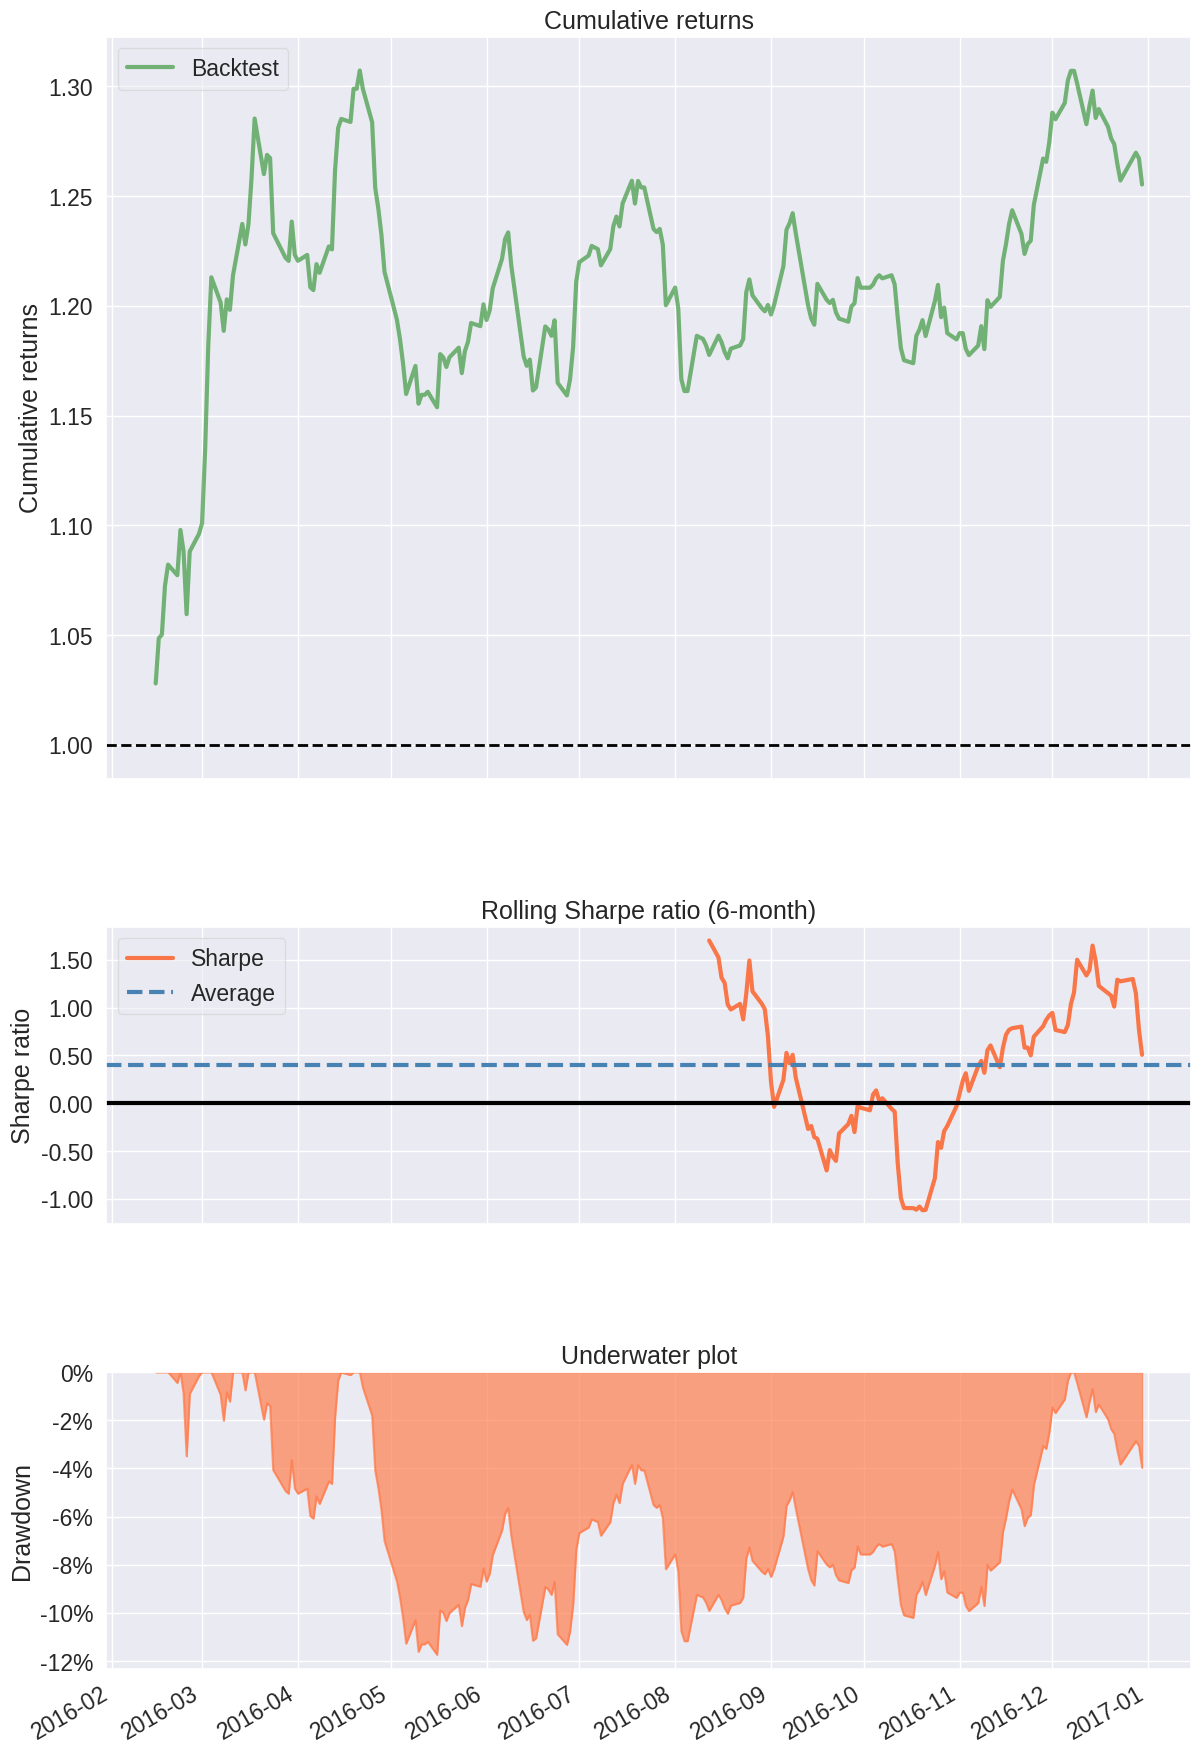

In [175]:
pf.create_simple_tear_sheet(df['strategy_returns'])



---

#THE END



---

